In [1]:
import requests
import csv
import pytz
import time
from datetime import datetime, timedelta

In [10]:
start = datetime(2011, 7, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 =  ['128.8.10.90', '199.7.91.13']
prefix6 = '2001:500:2D::D'

#### Helper methods

In [11]:
def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_state = []
    if data:
        for item in data:
            route_info = {
                'peer': item['path'][0],
                'root': item['path'][-1],
                'as_path': list(deduplicate(item['path']))
            }
            bgp_state.append(route_info)

    peer = [item['peer'] for item in bgp_state]

    return bgp_state, peer

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

#### Do calculation

In [12]:
utc = pytz.utc
with open('d-root-mutual-as-path-stats.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter=',')
    # csv header first
    writer.writerow(['time', 'identical', 'diff', 'v4_longer', 'v4_shorter'])
    cur_date = start
    while cur_date <= stop:
        print(cur_date)
        
        utc_dt = utc.localize(cur_date)
        timestamp = int(time.mktime(utc_dt.timetuple()))
         
        pfx4 = prefix4[0] if timestamp < 1357171200 else prefix4[1]  # changed IPv4 address at 2013-01-03
        
        bgp_state4, peer4 = get_peers(pfx4, timestamp)
        bgp_state6, peer6 = get_peers(prefix6, timestamp)
        
        mutual_peers = list(set(peer4) & set(peer6))
        
        mutual_peers_stat = get_peers_stat(mutual_peers, bgp_state4, bgp_state6)
        
        time_str = cur_date.strftime('%Y-%m-%d')
        result_all = len([i['peer'] for i in mutual_peers_stat])
        result_identical = len([i['peer'] for i in mutual_peers_stat if i['similar'] == 1])
        result_diff = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) == len(i['path6']) and i['similar'] == 0])
        result_v4_longer = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) > len(i['path6'])])
        result_v4_shorter = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) < len(i['path6'])])
        
        writer.writerow((time_str, result_identical, result_diff, result_v4_longer, result_v4_shorter))
        
        year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
        month = 1 if cur_date.month == 12 else cur_date.month + 1
        cur_date = datetime(year, month, 1, 1, 0, 0)
    
    

2011-07-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=128.8.10.90&timestamp=1309478400
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2D::D&timestamp=1309478400
2011-08-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=128.8.10.90&timestamp=1312156800
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2D::D&timestamp=1312156800
2011-09-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=128.8.10.90&timestamp=1314835200
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2D::D&timestamp=1314835200
2011-10-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=128.8.10.90&timestamp=1317427200
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2D::D&timestamp=1317427200
2011-11-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=128.8.10.90&timestamp=13201056

### Draw some graphs

In [2]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [3]:
df = pd.read_csv('d-root-mutual-as-path-stats.csv', index_col=0)
df

,identical,diff,v4_longer,v4_shorter
time,,,,
2011-07-01,4,23,10,4
2011-08-01,2,23,9,4
2011-09-01,4,25,6,4
2011-10-01,3,27,10,4
2011-11-01,3,28,9,3
2011-12-01,4,27,8,3
2012-01-01,4,17,7,2
2012-02-01,3,30,9,1
2012-03-01,4,30,9,1


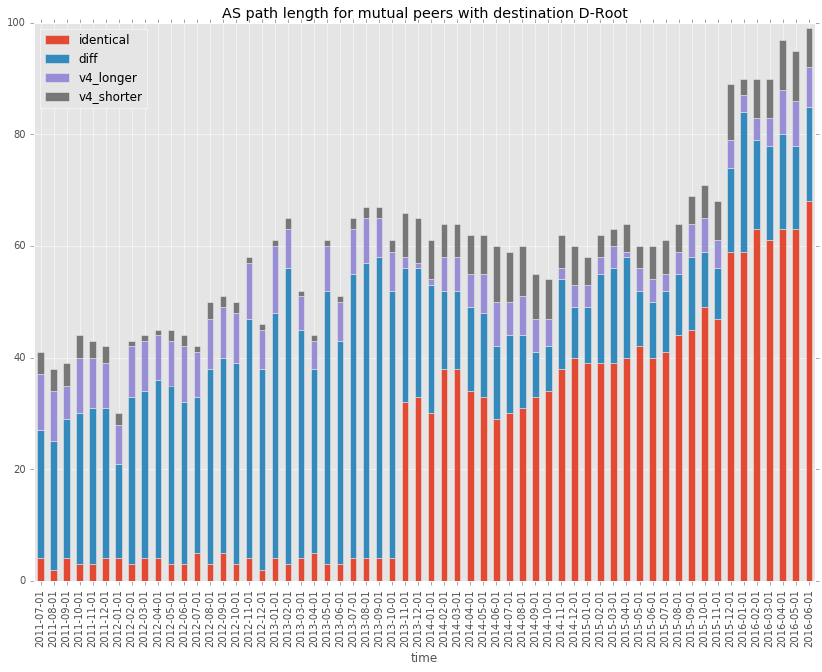

In [6]:
df.plot.bar(stacked=True, figsize=(14,10), title='AS path length for mutual peers with destination D-Root')

# RQ: How different is IPv4 and IPv6 catchment areas?

The following RQs illustrate catchment area differences at a specific time (1464739200, or 2013-06-01)

## RQ.1 IPv4/IPv6 peer degree distribution?

In [4]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests

matplotlib.style.use('ggplot')

timestamp = 1464739200 # 2013-06-01

prefix4 =  '199.7.91.13' # use this IP address during the given timestamp
prefix6 = '2001:500:2D::D'

Find the mutual peers

In [5]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
#             bgp_data[item['path'][0]] = list(deduplicate(item['path']))
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers

data4, peer4 = get_peers(prefix4, timestamp)
data6, peer6 = get_peers(prefix6, timestamp)

mutual_peers = list(set(peer4) & set(peer6))

get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=199.7.91.13&timestamp=1464739200
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:2D::D&timestamp=1464739200


then, find mutual peers with different path

In [6]:
mutual_peers_diff = {}

for peer in mutual_peers:
    if data4[peer]['path'] != data6[peer]['path']:
        mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}

Data processing 

In [8]:
from pandas import DataFrame

processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')

for index, row in processed_data.iterrows():
    processed_data.set_value(index, 'len4', len(row['path4']))
    processed_data.set_value(index, 'len6', len(row['path6']))
processed_data

,path4,path6,collector,len4,len6
286,"[286, 2914, 42, 27]","[286, 42, 27]","LINX, London",4.0,3.0
513,"[513, 21320, 2603, 42, 27]","[513, 21320, 6939, 42, 27]","CIXP, Geneva",5.0,5.0
680,"[680, 20965, 11537, 10886, 27]","[680, 6939, 42, 27]","Frankfurt, Germany",5.0,4.0
5396,"[5396, 6762, 42, 27]","[5396, 6939, 42, 27]","Milan, Italy",4.0,4.0
8426,"[8426, 42, 27]","[8426, 6939, 42, 27]","France-IX, Paris",3.0,4.0
8455,"[8455, 2914, 42, 27]","[8455, 6939, 42, 27]","AMS-IX and NL-IX, Amsterdam",4.0,4.0
12637,"[12637, 2914, 42, 27]","[12637, 6939, 42, 27]","Milan, Italy",4.0,4.0
12859,"[12859, 2914, 42, 27]","[12859, 6939, 42, 27]","AMS-IX and NL-IX, Amsterdam",4.0,4.0
14840,"[14840, 42, 27]","[14840, 6939, 42, 27]","Sao Paulo, Brazil",3.0,4.0
15435,"[15435, 3257, 42, 27]","[15435, 6939, 42, 27]","AMS-IX and NL-IX, Amsterdam",4.0,4.0


**Plot**

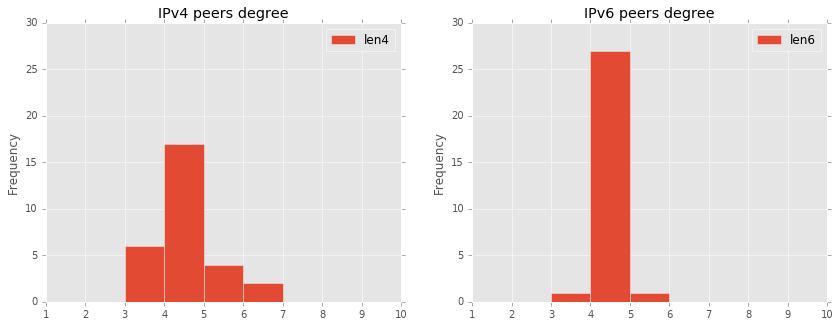

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)

processed_data[['len4']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[0], ylim=(0,30), title='IPv4 peers degree')
processed_data[['len6']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[1], ylim=(0,30), title='IPv6 peers degree')

## RQ.2 AS path average length?

In [12]:
avg4 = processed_data['len4'].mean()
avg6 = processed_data['len6'].mean()

print('IPv4 average path length: {}'.format(avg4))
print('IPv6 average path length: {}'.format(avg6))

IPv4 average path length: 4.068965517241379
IPv6 average path length: 4.0


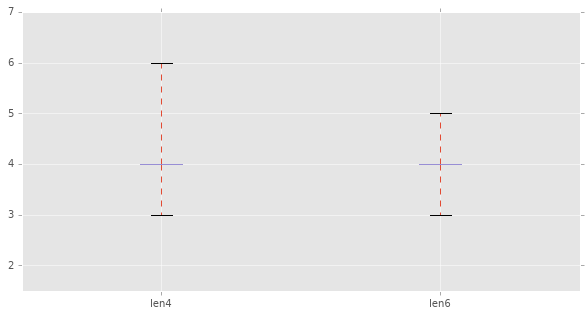

In [14]:
processed_data[['len4', 'len6']].plot.box(figsize=(10,5), ylim=(1.5,7))
plt.show()

## RQ.3 ASes most frequently seen?

### IPv4

In [15]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

res = []

for item in processed_data['path4']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv4 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 


Most frequently seen ASes in IPv4 AS paths:
42	25
2914	7
10886	4
174	3
43100	3
10429	2
3549	2
12956	2
6762	2
20965	1
31025	1
21320	1
3356	1
2603	1
1916	1
11537	1
12586	1
3257	1
8943	1


Most frequently seen per degree (degree is as seen from Root ASN)

In [16]:
max = processed_data['len4'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path4']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	42	25
	10886	4
(*) Hop 2:
	2914	7
	174	3
	43100	3
	6762	2
	3549	2
	47872	1
	31025	1
	1916	1
	2603	1
	51405	1
	11537	1
	49463	1
	14840	1
	3257	1
	15547	1
	8426	1
	8943	1
(*) Hop 3:
	12956	2
	15435	1
	8455	1
	21320	1
	50763	1
	28941	1
	5396	1
	52888	1
	41497	1
	3356	1
	12637	1
	286	1
	20965	1
	29608	1
	28329	1
	12586	1
	49835	1
	15605	1
	59689	1
	22548	1
	12859	1
	50620	1
(*) Hop 4:
	10429	2
	680	1
	513	1
	57821	1
	51185	1
(*) Hop 5:
	262317	1
	53070	1


### IPv6

In [17]:
res = []

for item in processed_data['path6']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv6 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 

Most frequently seen ASes in IPv6 AS paths:
42	29
6939	27
21320	1
44217	1


most frequently seen per degree

In [18]:
max = processed_data['len6'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path6']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	42	29
(*) Hop 2:
	6939	27
	44217	1
	286	1
(*) Hop 3:
	47872	1
	15435	1
	8455	1
	21320	1
	50763	1
	59689	1
	28941	1
	53070	1
	51405	1
	5396	1
	52888	1
	41497	1
	12637	1
	15547	1
	51185	1
	680	1
	28329	1
	8426	1
	49835	1
	262317	1
	57821	1
	29608	1
	15605	1
	49463	1
	14840	1
	22548	1
	12859	1
	50620	1
(*) Hop 4:
	513	1


## RQ.4 For shorter IPv6 path, which ASes frequently appear as transit?

In [19]:
temp= []
for item in processed_data.iterrows():
#     print(item[1]['path4'])
    if item[1]['len4'] > item[1]['len6']:
#         print('v4: {}\tv6: {}'.format(item[1]['path4'], item[1]['path6']))
        for asn in item[1]['path6'][1:-1]:
            temp.append(asn)

results = most_common(temp)
for result in results:
    print('{}\t{}'.format(result[0], result[1]))

42	6
6939	5


## RQ.5 For peers with same path length but different path, how different is it?

calculate the percentage of different AS hop, and find out which ASes are frequently appear in the IPv6 path

In [21]:
temp = []
for item in processed_data.iterrows():
    if len(item[1]['path4']) == len(item[1]['path6']):
#         print('v4:{}\t\t\tv6:{}'.format(item[1]['path4'][1:-1], item[1]['path6'][1:-1]))
        diff_counter = 0
        path_length = len(item[1]['path4'])
        for i in range(0, path_length):
            if item[1]['path4'][i] != item[1]['path6'][i]:
                temp.append(item[1]['path6'][i])
                diff_counter += 1
        diff_pct = (diff_counter / path_length) * 100
        print('Peer {}: \tlength:{} \tdifference: {}%'.format(item[0], path_length, diff_pct))

print('\nMost common ASes appear in IPv6 path that differs with IPv4 path')
results = most_common(temp)
for result in results:
    print('\t{}\t{}'.format(result[0], result[1]))
    

Peer 513: 	length:5 	difference: 20.0%
Peer 5396: 	length:4 	difference: 25.0%
Peer 8455: 	length:4 	difference: 25.0%
Peer 12637: 	length:4 	difference: 25.0%
Peer 12859: 	length:4 	difference: 25.0%
Peer 15435: 	length:4 	difference: 25.0%
Peer 15605: 	length:4 	difference: 50.0%
Peer 22548: 	length:4 	difference: 25.0%
Peer 28329: 	length:4 	difference: 25.0%
Peer 28941: 	length:4 	difference: 50.0%
Peer 29608: 	length:4 	difference: 25.0%
Peer 41497: 	length:4 	difference: 50.0%
Peer 49835: 	length:4 	difference: 25.0%
Peer 50620: 	length:4 	difference: 25.0%
Peer 50763: 	length:4 	difference: 25.0%
Peer 52888: 	length:4 	difference: 25.0%
Peer 59689: 	length:4 	difference: 25.0%

Most common ASes appear in IPv6 path that differs with IPv4 path
	6939	17
	42	3


## RQ.6 Can we correlate the path difference to their physical location? (based on the location of RIS collector)?

In [22]:
peer_location = processed_data.groupby('collector')
peer_location['collector'].count().sort_values(ascending=False)

collector
Sao Paulo, Brazil              6
Milan, Italy                   6
France-IX, Paris               6
AMS-IX and NL-IX, Amsterdam    4
RIPE NCC, Amsterdam            2
Stockholm, Sweden              1
LINX, London                   1
Frankfurt, Germany             1
CIXP, Geneva                   1
CATNIX, Barcelona              1
Name: collector, dtype: int64

**which collectors see the most peers with shorter IPv6 path?**

In [23]:
v6_shorter = processed_data[processed_data.len4 > processed_data.len6].groupby('collector')
v6_shorter['collector'].count().sort_values(ascending=False)

collector
Sao Paulo, Brazil      2
RIPE NCC, Amsterdam    1
Milan, Italy           1
LINX, London           1
Frankfurt, Germany     1
Name: collector, dtype: int64

**which collectors see the most peers with shorter IPv4 path?**

In [24]:
v4_shorter = processed_data[processed_data.len4 < processed_data.len6].groupby('collector')
v4_shorter['collector'].count().sort_values(ascending=False)

collector
France-IX, Paris     4
Stockholm, Sweden    1
Sao Paulo, Brazil    1
Name: collector, dtype: int64

# RQ: How do IPv4 and IPv6 catchment areas evolve over time?

Note that here we only use mutual peers that have different IPv4/IPv6 path

## RQ.1 IPv4/IPv6 peer degree distribution over time?

In [1]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests
from datetime import datetime
import pytz
import time
import csv
from pandas import DataFrame

# matplotlib.style.use('ggplot')

# timestamp = 1464739200 # 2013-06-01
# stop = datetime(2008, 6, 1, 1, 0, 0)
utc = pytz.utc

start = datetime(2011, 7, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 =  ['128.8.10.90', '199.7.91.13']
prefix6 = '2001:500:2D::D'

csv_dir = 'datasets/d/'

*Helper methods*

In [2]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
#     print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
#             bgp_data[item['path'][0]] = list(deduplicate(item['path']))
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers


def get_mutual_peer_with_diff_paths(timestamp):
    """
    get mutual peer with different IPv4/IPv6 paths
    """
    if timestamp < 1357171200:
        data4, peer4 = get_peers(prefix4[0], timestamp)
    else:
        data4, peer4 = get_peers(prefix4[1], timestamp)
    data6, peer6 = get_peers(prefix6, timestamp)

    mutual_peers = list(set(peer4) & set(peer6))

    mutual_peers_diff = {}

    for peer in mutual_peers:
    #     print(peer)
        if data4[peer]['path'] != data6[peer]['path']:
    #         print(data4[peer]['path'])
            mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}
    
    return mutual_peers_diff

### Get data, write to .csv file

Do it only once!!!

In [31]:
result = {}
cur_date = start
print('start.....')
while cur_date <= stop:
    # do something here
    utc_dt = utc.localize(cur_date)
    timestamp = int(time.mktime(utc_dt.timetuple()))
    
    mutual_peers_diff = get_mutual_peer_with_diff_paths(timestamp)

    processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')

    for index, row in processed_data.iterrows():
        processed_data.set_value(index, 'len4', len(row['path4']))
        processed_data.set_value(index, 'len6', len(row['path6']))
    
    path_file = '{}{}-path.csv'.format(csv_dir, timestamp)
    processed_data.to_csv(path_file, sep='\t')
    
    # increment cur_date
    year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
    month = 1 if cur_date.month == 12 else cur_date.month + 1
    cur_date = datetime(year, month, 1, 1, 0, 0)

print('stop...')

start.....
stop...


### Data Analysis

get peer's degree for both IPv4 and IPv6

In [3]:
import os

In [4]:
result4 = {}
result6 = {}
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4'].value_counts()
        result4[timestamp] = res4
        res6 = opened_file['len6'].value_counts()
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()
print('finish.')

finish.


### Plot

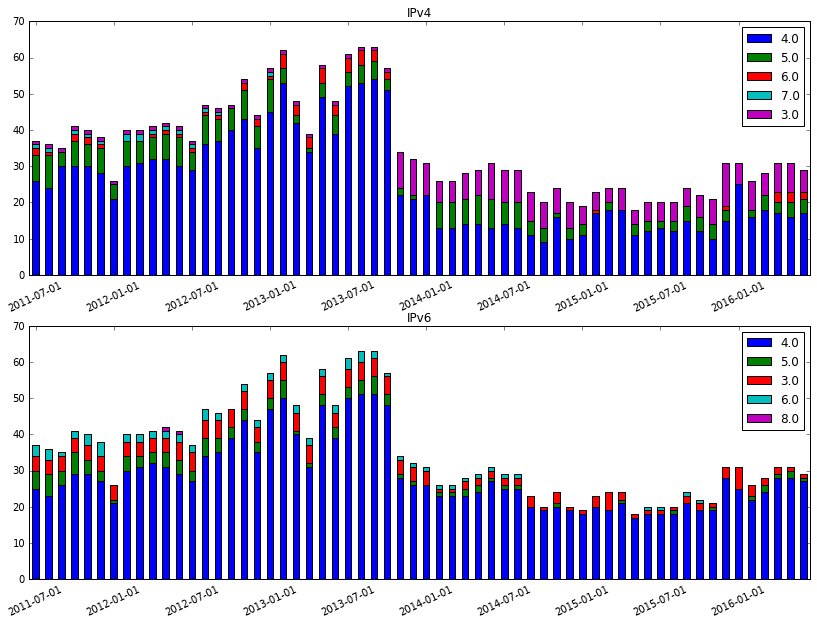

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1)

# ipv4
plot_result4 = DataFrame.from_dict(result4, orient='index')
plot_result6 = DataFrame.from_dict(result6, orient='index')

plot4 = plot_result4.plot.bar(stacked=True, ax=axes[0], figsize=(14,10), title='IPv4')
plot6 = plot_result6.plot.bar(stacked=True, ax=axes[1], figsize=(14,10), title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.2 AS path average length?

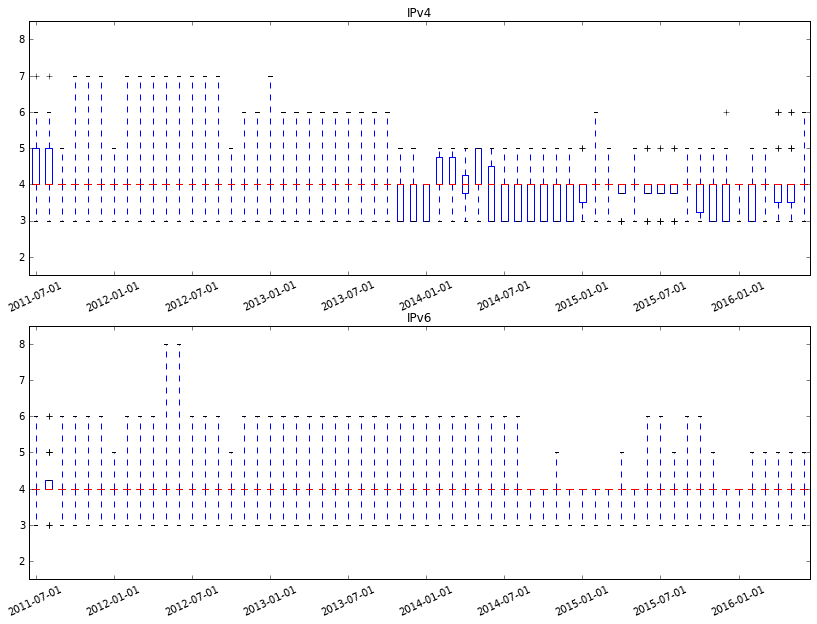

In [6]:
result4 = {}
result6 = {}
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4']
        res6 = opened_file['len6']
        result4[timestamp] = res4
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()

plot_result4 = DataFrame.from_dict(result4)
plot_result6 = DataFrame.from_dict(result6)


################
# Plot
################
fig, axes = plt.subplots(nrows=2, ncols=1)

plot4 = plot_result4.plot.box(figsize=(14,10), ax=axes[0], ylim=(1.5,8.5), title='IPv4')
plot6 = plot_result6.plot.box(figsize=(14,10), ax=axes[1], ylim=(1.5,8.5), title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.3 Most frequently seen ASes on the path?

### IPv4

In [7]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path4']:
            # transform string of AS path into python's list
            path4 = item[1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            # exclude origin AS and probe AS
            for i in path4[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv4 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv4 AS paths (2011-07-01):
22925	33
6939	21
174	11
10886	4
209	4
12956	3
10429	3
3356	2
25512	1
53131	1

[*] Most frequently seen ASes in IPv4 AS paths (2011-08-01):
22925	29
6939	18
174	10
10886	7
209	5
12956	2
20965	2
19401	2
3356	2
10429	2

[*] Most frequently seen ASes in IPv4 AS paths (2011-09-01):
22925	31
6939	23
174	7
7922	3
33657	3
209	1
10886	1
16735	1
25512	1
3257	1

[*] Most frequently seen ASes in IPv4 AS paths (2011-10-01):
22925	36
6939	23
174	12
7922	3
33657	3
12956	3
10886	2
10429	2
16735	2
18881	1

[*] Most frequently seen ASes in IPv4 AS paths (2011-11-01):
22925	34
6939	23
174	10
7922	4
33657	4
12956	3
10886	2
10429	2
16735	2
18881	1

[*] Most frequently seen ASes in IPv4 AS paths (2011-12-01):
22925	34
6939	23
174	10
7922	4
33657	4
6453	2
12956	2
16735	2
18881	1
20485	1

[*] Most frequently seen ASes in IPv4 AS paths (2012-01-01):
22925	22
6939	14
174	7
7922	4
33657	4
6453	2
3257	1
20485	1

[*] Most frequently seen ASes in IPv4 AS

### IPv6

In [8]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path6']:
            # transform string of AS path into python's list
            path6 = item[1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            # exclude origin AS and probe AS
            for i in path6[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv6 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv6 AS paths (2011-07-01):
10886	37
6939	28
16735	4
11537	3
3257	2
13030	1
20965	1
53131	1
15685	1
29208	1

[*] Most frequently seen ASes in IPv6 AS paths (2011-08-01):
10886	36
6939	25
11537	4
20965	3
11164	3
16735	3
13030	1
53131	1
15685	1
29208	1

[*] Most frequently seen ASes in IPv6 AS paths (2011-09-01):
10886	35
6939	25
11164	3
3257	2
11537	1
16735	1
20965	1
29208	1
3356	1
13030	1

[*] Most frequently seen ASes in IPv6 AS paths (2011-10-01):
10886	41
6939	27
11537	3
3257	3
11164	3
16735	3
20965	1
3356	1
53131	1
15685	1

[*] Most frequently seen ASes in IPv6 AS paths (2011-11-01):
10886	40
6939	27
11537	3
3257	3
16735	3
11164	2
3549	2
15685	1
53131	1
174	1

[*] Most frequently seen ASes in IPv6 AS paths (2011-12-01):
10886	38
6939	26
11537	3
11164	3
3549	3
16735	2
18881	1
15685	1
53131	1
174	1

[*] Most frequently seen ASes in IPv6 AS paths (2012-01-01):
10886	26
6939	16
3257	3
11164	2
1273	1
8218	1

[*] Most frequently seen ASes in IPv6 AS path

## RQ.4a For shorter IPv6 path, which ASes frequently appear as transit?

In [9]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] > item[1]['len6']:
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            for asn in path6[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))

[*] at 2011-07-01:
	10886	10
	6939	7
	16735	3
	53131	1
[*] at 2011-08-01:
	10886	9
	6939	6
	16735	2
	53131	1
[*] at 2011-09-01:
	10886	5
	6939	2
[*] at 2011-10-01:
	10886	10
	6939	5
	16735	2
	53131	1
	3257	1
[*] at 2011-11-01:
	10886	9
	6939	4
	16735	2
	53131	1
	3257	1
[*] at 2011-12-01:
	10886	8
	6939	3
	53131	1
	1273	1
	11164	1
[*] at 2012-01-01:
	10886	7
	6939	2
	1273	1
	3257	1
[*] at 2012-02-01:
	10886	9
	6939	2
	18881	1
	3257	1
	11537	1
[*] at 2012-03-01:
	10886	9
	6939	3
	18881	1
	11537	1
	1273	1
[*] at 2012-04-01:
	10886	8
	6939	3
	53131	1
	1273	1
	11164	1
[*] at 2012-05-01:
	10886	8
	6939	3
	53131	1
	1273	1
	11164	1
[*] at 2012-06-01:
	10886	10
	6939	4
	53131	1
	30071	1
	11164	1
[*] at 2012-07-01:
	10886	8
	6939	3
	53131	1
	11164	1
	16735	1
[*] at 2012-08-01:
	10886	9
	6939	4
	1273	1
	53131	1
	16735	1
[*] at 2012-09-01:
	10886	9
	6939	3
	53131	1
	1273	1
	11164	1
[*] at 2012-10-01:
	10886	9
	6939	3
	1273	1
	11164	1
[*] at 2012-11-01:
	10886	10
	6939	3
	1273	1
	11164	1
	3257	1
[*

## RQ.4b For shorter IPv6 path, how different is it?

In [10]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) > len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path4) - len(path6), (len(path4) - len(path6)) / len(path4) * 100))


---------------------------------------------------------------
 date: 2011-07-01
---------------------------------------------------------------
3257	4	3	1	25.00%
4589	5	4	1	20.00%
8426	5	4	1	20.00%
9002	5	3	2	40.00%
19151	4	3	1	25.00%
22548	6	5	1	16.67%
28289	7	6	1	14.29%
29140	5	4	1	20.00%
29686	5	4	1	20.00%
53070	6	5	1	16.67%

---------------------------------------------------------------
 date: 2011-08-01
---------------------------------------------------------------
3257	4	3	1	25.00%
4589	5	4	1	20.00%
8426	5	4	1	20.00%
9002	5	3	2	40.00%
19151	4	3	1	25.00%
28289	7	6	1	14.29%
29140	5	4	1	20.00%
29686	5	4	1	20.00%
53070	6	5	1	16.67%

---------------------------------------------------------------
 date: 2011-09-01
---------------------------------------------------------------
3257	4	3	1	25.00%
8426	5	4	1	20.00%
9002	4	3	1	25.00%
19151	4	3	1	25.00%
29140	5	4	1	20.00%

---------------------------------------------------------------
 date: 2011-10-01
-------------------------------

## RQ.5a For shorter IPv4 path, which ASes frequently appear as transit?

In [11]:
for file in sorted(os.listdir('datasets/m/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/m/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] < item[1]['len6']:
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            for asn in path4[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('\n[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))


[*] at 2008-03-01:
	1299	2

[*] at 2008-04-01:

[*] at 2008-05-01:
	1299	1

[*] at 2008-06-01:

[*] at 2008-07-01:

[*] at 2008-08-01:

[*] at 2008-09-01:

[*] at 2008-10-01:

[*] at 2008-11-01:

[*] at 2008-12-01:

[*] at 2009-01-01:

[*] at 2009-02-01:

[*] at 2009-03-01:

[*] at 2009-04-01:

[*] at 2009-05-01:

[*] at 2009-06-01:

[*] at 2009-07-01:

[*] at 2009-08-01:

[*] at 2009-09-01:

[*] at 2009-10-01:

[*] at 2009-11-01:

[*] at 2009-12-01:

[*] at 2010-01-01:
	3257	1

[*] at 2010-02-01:
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-03-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-04-01:
	3257	2
	1125	1
	1103	1

[*] at 2010-05-01:
	6453	1
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-06-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-07-01:

[*] at 2010-08-01:

[*] at 2010-09-01:

[*] at 2010-10-01:
	2200	1
	20965	1
	27750	1

[*] at 2010-11-01:
	2200	1
	24490	1
	20965	1

[*] at 2010-12-01:

[*] at 2011-01-01:
	2200	1
	24490	1
	20965	1

[*] at 2011-02-01:
	2200	1
	24490	1
	

## RQ.5b For shorter IPv4 path, how different is it?

In [12]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) < len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path6) - len(path4), (len(path6) - len(path4)) / len(path6) * 100))


---------------------------------------------------------------
 date: 2011-07-01
---------------------------------------------------------------
1930	4	5	1	20.00%
6881	5	6	1	16.67%
28917	4	6	2	33.33%
35369	4	5	1	20.00%

---------------------------------------------------------------
 date: 2011-08-01
---------------------------------------------------------------
1930	4	5	1	20.00%
6881	5	6	1	16.67%
28917	4	6	2	33.33%
35369	4	5	1	20.00%

---------------------------------------------------------------
 date: 2011-09-01
---------------------------------------------------------------
1930	4	5	1	20.00%
6881	5	6	1	16.67%
28917	4	5	1	20.00%
35369	4	5	1	20.00%

---------------------------------------------------------------
 date: 2011-10-01
---------------------------------------------------------------
1930	4	5	1	20.00%
6881	5	6	1	16.67%
28917	4	5	1	20.00%
35369	4	5	1	20.00%

---------------------------------------------------------------
 date: 2011-11-01
---------------------------------

## RQ.6 For peers with same AS path length but different path, how different is it?

In [15]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp = []
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    for item in opened_file.iterrows():
        if len(item[1]['path4']) == len(item[1]['path6']):
            # transform string into list
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            
            diff_counter = 0
            path_length = len(path4)
            for i in range(0, path_length):
                if path4[i] != path6[i]:
                    temp.append(path6[i])
                    diff_counter += 1
            diff_pct = (diff_counter / path_length) * 100
            print('Peer {0}: \tlength:{1} \tdifference: {2:.2f}%'.format(item[0], path_length, diff_pct))
            

    print('\nMost common ASes appear in IPv6 path that differs with IPv4 path:')
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))



---------------------------------------------------------------
 date: 2011-07-01
---------------------------------------------------------------
Peer 1299: 	length:4 	difference: 25.00%
Peer 6667: 	length:4 	difference: 25.00%
Peer 6939: 	length:3 	difference: 33.33%
Peer 8447: 	length:4 	difference: 25.00%
Peer 8607: 	length:4 	difference: 25.00%
Peer 8758: 	length:4 	difference: 25.00%
Peer 9189: 	length:4 	difference: 25.00%
Peer 12637: 	length:4 	difference: 50.00%
Peer 12859: 	length:4 	difference: 25.00%
Peer 13030: 	length:4 	difference: 25.00%
Peer 13237: 	length:4 	difference: 25.00%
Peer 15469: 	length:4 	difference: 25.00%
Peer 16735: 	length:4 	difference: 25.00%
Peer 28138: 	length:5 	difference: 20.00%
Peer 29636: 	length:4 	difference: 25.00%
Peer 34695: 	length:4 	difference: 25.00%
Peer 39912: 	length:4 	difference: 50.00%
Peer 42708: 	length:4 	difference: 25.00%

Most common ASes appear in IPv6 path that differs with IPv4 path:
	10886	18
	3257	2

------------------

## RQ.7 Can we correlate the path difference to their physical location?

In [17]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        peer_location = opened_file.groupby('collector')
        result = peer_location['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2011-07-01
---------------------------------------------------------------
collector
Frankfurt, Germany             7
Sao Paulo, Brazil              5
VIX, Vienna                    4
RIPE NCC, Amsterdam            4
Palo Alto, USA                 4
LINX, London                   4
New York (NY), USA             2
Moscow, Russia                 2
Milan, Italy                   2
AMS-IX and NL-IX, Amsterdam    2
Stockholm, Sweden              1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2011-08-01
---------------------------------------------------------------
collector
Frankfurt, Germany             7
Palo Alto, USA                 5
VIX, Vienna                    4
Sao Paulo, Brazil              4
RIPE NCC, Amsterdam            4
LINX, London                   4
AMS-IX and NL-IX, Amsterdam    3
New York (NY), USA             2
Moscow, Russia               

### which collectors see the most peers with shorter IPv6 path?

In [20]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v6_shorter = opened_file[opened_file.len4 > opened_file.len6].groupby('collector')
        result = v6_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2011-07-01
---------------------------------------------------------------
collector
Frankfurt, Germany    4
Sao Paulo, Brazil     3
Palo Alto, USA        1
New York (NY), USA    1
Moscow, Russia        1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2011-08-01
---------------------------------------------------------------
collector
Frankfurt, Germany    4
Sao Paulo, Brazil     2
Palo Alto, USA        1
New York (NY), USA    1
Moscow, Russia        1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2011-09-01
---------------------------------------------------------------
collector
Frankfurt, Germany    2
Palo Alto, USA        1
New York (NY), USA    1
Moscow, Russia        1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2011-10-01
--------------------

### which collectors see the most peers with shorter IPv4 path?

In [21]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v4_shorter = opened_file[opened_file.len4 < opened_file.len6].groupby('collector')
        result = v4_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2011-07-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam    2
VIX, Vienna            1
Moscow, Russia         1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2011-08-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam    2
VIX, Vienna            1
Moscow, Russia         1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2011-09-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam    2
VIX, Vienna            1
Moscow, Russia         1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2011-10-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam    2
VIX, Vienna            1
Moscow,